# KFP Challenge Lab 3

In this challenge lab, we'll extend the pipeline developed in the challenge lab 2 to add data pipeline.

**Learning Objectives:**
1. Learn how to build a Python lightweight component from scratch.
1. Learn how to compose pipeline with multiple components.

## Setup

In [16]:
from datetime import datetime

from google.cloud import aiplatform

In [17]:
REGION = "us-central1"
PROJECT_ID = !(gcloud config get-value project)
PROJECT_ID = PROJECT_ID[0]

In [18]:
# Set `PATH` to include the directory containing KFP CLI
PATH = %env PATH
%env PATH=/home/jupyter/.local/bin:{PATH}

env: PATH=/home/jupyter/.local/bin:/home/jupyter/.local/bin:/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin::/home/jupyter/.local/bin:


### Build the trainer image

The training step in the pipeline will require a custom training container. The custom training image is defined in `trainer_image_vertex/Dockerfile`.

Let's now build and push this trainer container to the container registry:

In [96]:
ARTIFACT_REGISTRY_DIR = "asl-artifact-repo"
IMAGE_NAME = "trainer_image_covertype_vertex"
IMAGE_TAG = "latest"
TRAINING_CONTAINER_IMAGE_URI = f"us-docker.pkg.dev/{PROJECT_ID}/{ARTIFACT_REGISTRY_DIR}/{IMAGE_NAME}:{IMAGE_TAG}"
TRAINING_CONTAINER_IMAGE_URI

'us-docker.pkg.dev/takumiohym-sandbox/asl-artifact-repo/trainer_image_covertype_vertex:latest'

To match the ml framework version we use at training time while serving the model, we will have to supply the following serving container to the pipeline:

In [97]:
SERVING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest"
)

**Note:** If you change the version of the training ml framework you'll have to supply a serving container with matching version (see [pre-built containers for prediction](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)).

## Challenge Lab 3

In this lab, we'll extend the pipeline developed in [challenge_lab_2.ipynb](./challenge_lab_2.ipynb) , automating dataset creation and export as we did in the [walkthrough notebook](../../walkthrough/solutions/kfp_walkthrough_vertex.ipynb).<br>
So far, the pipelines assumes the datasets are already created, but here we complete the full pipeline by adding this capability.

To add this capability, we add these two elements to the pipeline by modifying the [`pipeline_vertex/extract_bq.py`](./pipeline_vertex/extract_bq.py) and [`pipeline.py`](./pipeline_vertex/pipeline.py). 

- **Create data split (for both training and validation)**
  - Use the [prebuild BigqueryQueryJobOp component](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-2.8.0/api/v1/bigquery.html?h=bigqueryqueryjobop#)
    - Note that this component returns a [google.BQTable Artifact](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-2.8.0/api/artifact_types.html#google_cloud_pipeline_components.types.artifact_types.BQTable.schema)

  - For data split query, refer to the [walkthrough notebook](../../walkthrough/solutions/kfp_walkthrough_vertex.ipynb) we used.
- **Export data from BQ to GCS (for both training and validation)**
  - Open [`pipeline_vertex/extract_bq.py`](./pipeline_vertex/extract_bq.py) and define a Python lightweight component.
  - Use Python SDK API (https://cloud.google.com/bigquery/docs/exporting-data#python)
  - This component should take an `Input[Artifact]` which is a generic artifact importer. We use it to pass `google.BQTable Artifact`.


Open [pipeline_vertex/extract_bq.py](./pipeline_vertex/extract_bq.py) and [pipeline_vertex/pipeline.py](./pipeline_vertex/pipeline.py), and update following the instructions above.

**Tips: Search `TODO 3` to locate the sections you need to update.**

### Reference:
- Python lightweight component: https://www.kubeflow.org/docs/components/pipelines/v2/components/lightweight-python-components/
- Adding artifact output in KFP: https://www.kubeflow.org/docs/components/pipelines/v2/data-types/artifacts/#traditional-artifact-syntax 
- prebuild BigqueryQueryJobOp component: https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-2.8.0/api/v1/bigquery.html?h=bigqueryqueryjobop#
- Python SDK for BigQuery data export: https://cloud.google.com/bigquery/docs/exporting-data#python


### Expected Result
KFP Pipeline DAG (Extend the red rectangle section):

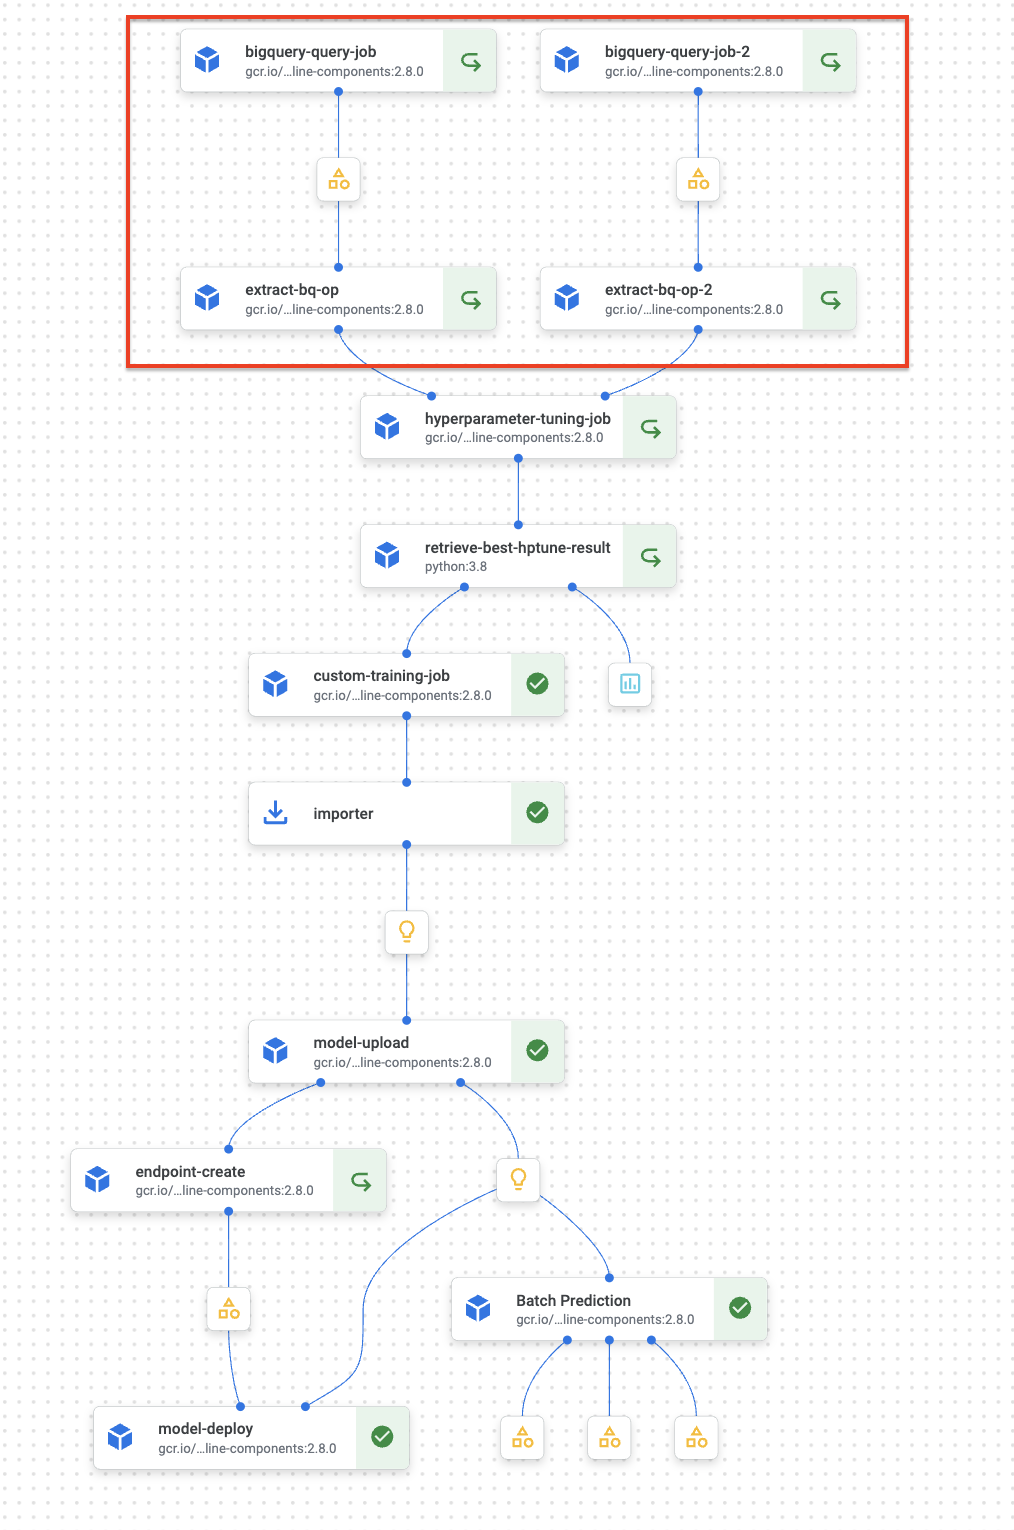


## Compile and run the pipeline

Let stat by defining the environment variables that will be passed to the pipeline compiler:

In [104]:
ARTIFACT_STORE = f"gs://{PROJECT_ID}-kfp-artifact-store"
PIPELINE_ROOT = f"{ARTIFACT_STORE}/pipeline"
DATA_ROOT = f"{ARTIFACT_STORE}/data"

TRAINING_FILE_PATH = f"{DATA_ROOT}/training/dataset.csv"
VALIDATION_FILE_PATH = f"{DATA_ROOT}/validation/dataset.csv"

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BASE_OUTPUT_DIR = f"{ARTIFACT_STORE}/models/{TIMESTAMP}"

%env PIPELINE_ROOT={PIPELINE_ROOT}
%env PROJECT_ID={PROJECT_ID}
%env REGION={REGION}
%env SERVING_CONTAINER_IMAGE_URI={SERVING_CONTAINER_IMAGE_URI}
%env TRAINING_CONTAINER_IMAGE_URI={TRAINING_CONTAINER_IMAGE_URI}
%env TRAINING_FILE_PATH={TRAINING_FILE_PATH}
%env VALIDATION_FILE_PATH={VALIDATION_FILE_PATH}
%env BASE_OUTPUT_DIR={BASE_OUTPUT_DIR}

env: PIPELINE_ROOT=gs://takumiohym-sandbox-kfp-artifact-store/pipeline
env: PROJECT_ID=takumiohym-sandbox
env: REGION=us-central1
env: SERVING_CONTAINER_IMAGE_URI=us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest
env: TRAINING_CONTAINER_IMAGE_URI=us-docker.pkg.dev/takumiohym-sandbox/asl-artifact-repo/trainer_image_covertype_vertex:latest
env: TRAINING_FILE_PATH=gs://takumiohym-sandbox-kfp-artifact-store/data/training/dataset.csv
env: VALIDATION_FILE_PATH=gs://takumiohym-sandbox-kfp-artifact-store/data/validation/dataset.csv
env: BASE_OUTPUT_DIR=gs://takumiohym-sandbox-kfp-artifact-store/models/20240421105628


Let us make sure that the `ARTIFACT_STORE` has been created, and let us create it if not:

In [105]:
!gsutil ls | grep ^{ARTIFACT_STORE}/$ || gsutil mb -l {REGION} {ARTIFACT_STORE}

gs://takumiohym-sandbox-kfp-artifact-store/


**Note:** In case the artifact store was not created and properly set before hand, you may need
to run in **CloudShell** the following command to allow Vertex AI to access it:

```
PROJECT_ID=$(gcloud config get-value project)
PROJECT_NUMBER=$(gcloud projects list --filter="name=$PROJECT_ID" --format="value(PROJECT_NUMBER)")
gcloud projects add-iam-policy-binding $PROJECT_ID \
    --member="serviceAccount:$PROJECT_NUMBER-compute@developer.gserviceaccount.com" \
    --role="roles/storage.objectAdmin"
```

#### Use the CLI compiler to compile the pipeline

We compile the pipeline from the Python file we generated into a JSON description using the following command:

In [106]:
PIPELINE_YAML = "covertype_kfp_pipeline-lab3.yaml"

In [107]:
!kfp dsl compile --py pipeline_vertex/pipeline.py --output $PIPELINE_YAML

/home/jupyter/asl-ml-immersion/notebooks/kubeflow_pipelines/pipelines/challenge_labs/covertype_kfp_pipeline-lab1.yaml


**Note:** You can also use the Python SDK to compile the pipeline:

```python
from kfp import compiler

compiler.Compiler().compile(
    pipeline_func=create_pipeline, 
    package_path=PIPELINE_YAML,
)

```

The result is the pipeline file. 

In [108]:
!head {PIPELINE_YAML}

# PIPELINE DEFINITION
# Name: covertype-kfp-pipeline
# Description: Kubeflow pipeline that tunes, trains, and deploys on Vertex
# Outputs:
#    retrieve-best-hptune-result-metrics_artifact: system.Metrics
components:
  comp-custom-training-job:
    executorLabel: exec-custom-training-job
    inputDefinitions:
      parameters:


### Deploy and run the pipeline package

In [109]:
EXPERIMENT_NAME = "kfp-covertype-experiment"

In [110]:
aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME,
    experiment_tensorboard=False,
)

pipeline = aiplatform.PipelineJob(
    display_name="covertype_kfp_pipeline_challenge_lab",
    template_path=PIPELINE_YAML,
    enable_caching=True,
)

pipeline.submit(experiment=EXPERIMENT_NAME)

Creating PipelineJob
PipelineJob created. Resource name: projects/237937020997/locations/us-central1/pipelineJobs/covertype-kfp-pipeline-20240421105649
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/237937020997/locations/us-central1/pipelineJobs/covertype-kfp-pipeline-20240421105649')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/covertype-kfp-pipeline-20240421105649?project=237937020997
Associating projects/237937020997/locations/us-central1/pipelineJobs/covertype-kfp-pipeline-20240421105649 to Experiment: kfp-covertype-experiment


Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.